In [1]:
import datetime as dt
import glob
import os
import shutil
import sys

sys.path.append("..")

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import utils
from openpyxl import load_workbook
from openpyxl.styles import Alignment, Font, PatternFill
from scipy import signal

plt.style.use("ggplot")
# alt.data_transformers.disable_max_rows()
alt.data_transformers.enable("json")

DataTransformerRegistry.enable('json')

# Tiltaksovervakingen: opsjon for kvalitetskontroll av analysedata
## Notebook 4: Exploring time series

This notebook considers patterns in individual time series (i.e. all the measurements from a particular station-parameter-depth combination). Considering individual series is a highly specific and targeted form of quality control, but with two main limitations: (i) the number of data points in any single series is small, so the statistical power to detect anomalies is reduced; and (ii) these methods tend to generate a lot of output information (i.e. list of potentially problematic data sereis), which must be reviewed manually.

## 1. Number of samples per month

The number of samples collected per month seems to vary both within the year and between sites. The code below counts the number of samples at each site in each month and year within the historic period (ignoring depth information). The minimum, median and maximum sampling frequency for each month (over all historic years) is then calculated and compared to the sampling frequency in the "new" dataset. Stations where the number of samples per month in "new" is **lower then the minimum for the corresponding month in the historic data are flagged as possible issues**.

In [2]:
# Choose dataset to process
lab = "Eurofins"
year = 2023
qtr = 2
version = 1
iqr_fac = 4

In [3]:
fold_path = f"../../output/{lab.lower()}_{year}_q{qtr}_v{version}"

In [4]:
# Read from SQLite
stn_df, df = utils.read_data_from_sqlite(lab, year, qtr, version)

# # Subset data to just the quarter of interest
# months_dict = {
#     "q1": [1, 2, 3],
#     "q2": [4, 5, 6],
#     "q3": [7, 8, 9],
#     "q4": [10, 11, 12],
# }
# months = months_dict[qtr]
# df = df[df["sample_date"].dt.month.isin(months)]

df.head()

,vannmiljo_code,sample_date,lab,period,depth1,depth2,ALK_mmol/l,ANC_µekv/l,CA_mg/l,CL_mg/l,...,N-NO3_µg/l N,N-TOT_µg/l N,NA_mg/l,P-TOT_µg/l P,PH_<ubenevnt>,RAL_µg/l Al,SIO2_µg/l Si,SO4_mg/l,TEMP_°C,TOC_mg/l C
0,002-105961,2023-04-10,Eurofins,new,0.0,0.0,NaN,NaN,3.4,NaN,...,NaN,NaN,NaN,NaN,6.4,NaN,NaN,NaN,4.0,NaN
1,002-105961,2023-04-17,Eurofins,new,0.0,0.0,NaN,NaN,2.1,NaN,...,NaN,NaN,NaN,NaN,5.9,NaN,NaN,NaN,NaN,NaN
2,002-105961,2023-04-24,Eurofins,new,0.0,0.0,NaN,NaN,1.2,NaN,...,NaN,NaN,NaN,NaN,5.6,NaN,NaN,NaN,3.0,NaN
3,002-105961,2023-05-01,Eurofins,new,0.0,0.0,0.03,52.0,1.3,0.93,...,160.0,310.0,0.37,7.9,5.3,56.0,981.840879,0.22,3.0,14.0
4,002-105961,2023-05-08,Eurofins,new,0.0,0.0,NaN,NaN,1.4,NaN,...,NaN,NaN,NaN,NaN,5.3,NaN,NaN,NaN,4.0,NaN


In [5]:
# Get years and months for samples
df["month"] = df["sample_date"].dt.month
df["year"] = df["sample_date"].dt.year
df["count"] = 1

# Separate 'old' and 'new' datasets
his_df = df.query("period == 'historic'").copy()
new_df = df.query("period == 'new'").copy()

# Get min, med and max samples per site and month in the old dataset (i.e. variation from year to year)
his_cnt_df = (
    his_df.groupby(["vannmiljo_code", "year", "month"]).count()["count"].reset_index()
)

his_cnt_df = (
    his_cnt_df.groupby(["vannmiljo_code", "month"])["count"]
    .agg(["min", "median", "max"])
    .reset_index()
)

# Get min, med and max samples per site and month in the new dataset
# These should all be the same, as 'new' should have only one year
new_cnt_df = (
    new_df.groupby(["vannmiljo_code", "year", "month"]).count()["count"].reset_index()
)

new_cnt_df = (
    new_cnt_df.groupby(["vannmiljo_code", "month"])["count"]
    .agg(["min", "median", "max"])
    .reset_index()
)

# Check min med and max are the same for 'new', then just keep one of them
assert (new_cnt_df["min"] == new_cnt_df["median"]).all() and (
    new_cnt_df["median"] == new_cnt_df["max"]
).all(), "The 'new' dataset contains samples from more than one year."

# Tidy
his_cnt_df.rename(
    {
        "min": "his_min",
        "median": "his_median",
        "max": "his_max",
    },
    axis="columns",
    inplace=True,
)
new_cnt_df.rename({"median": "new"}, axis="columns", inplace=True)
del new_cnt_df["min"], new_cnt_df["max"]

# Join
cnt_df = pd.merge(new_cnt_df, his_cnt_df, how="left", on=["vannmiljo_code", "month"])

# Identify sites and months where the smapling frequency in 'new' is lower than the
# minimum in the historic period
below_min_df = cnt_df[cnt_df["new"] < cnt_df["his_min"]].reset_index(drop=True)
below_min_stns = list(below_min_df["vannmiljo_code"].unique())

csv_path = os.path.join(fold_path, "samp_freq_below_historic_min.csv")
below_min_df.to_csv(csv_path, index=False)

print(
    f"There are {len(below_min_stns)} sites where the number of samples per month in the 'new' dataset "
    "is lower than the lowest sampling frequency in the historic period.\n"
)

below_min_df

There are 19 sites where the number of samples per month in the 'new' dataset is lower than the lowest sampling frequency in the historic period.



,vannmiljo_code,month,new,his_min,his_median,his_max
0,018-32157,4,3.0,4.0,4.0,5.0
1,020-79149,4,1.0,3.0,3.5,4.0
2,020-97010,4,1.0,3.0,3.0,3.0
3,020-97010,5,1.0,4.0,4.0,4.0
4,020-97010,6,1.0,2.0,2.0,2.0
5,021-28451,4,2.0,3.0,3.0,5.0
6,021-45780,4,1.0,2.0,2.0,2.0
7,022-97011,4,3.0,4.0,4.0,4.0
8,022-97011,6,2.0,3.0,3.0,3.0
9,026-97012,4,2.0,3.0,3.0,3.0


Black vertical lines on the red bars on the plot below show the standard deviation in the sampling frequency within the historic dataset. Months where the blue bars ("new" data) are substantially below the lower limits of the black lines may indicate missing samples. For example, during July, there are several cases where **the median number of samples in the historic data is 3, but the number of samples in the new data is just 1** (see also the table above). Is this expected?

/tmp/ipykernel_636/1409056040.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sn.catplot(
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.10/site-packages/numpy/c

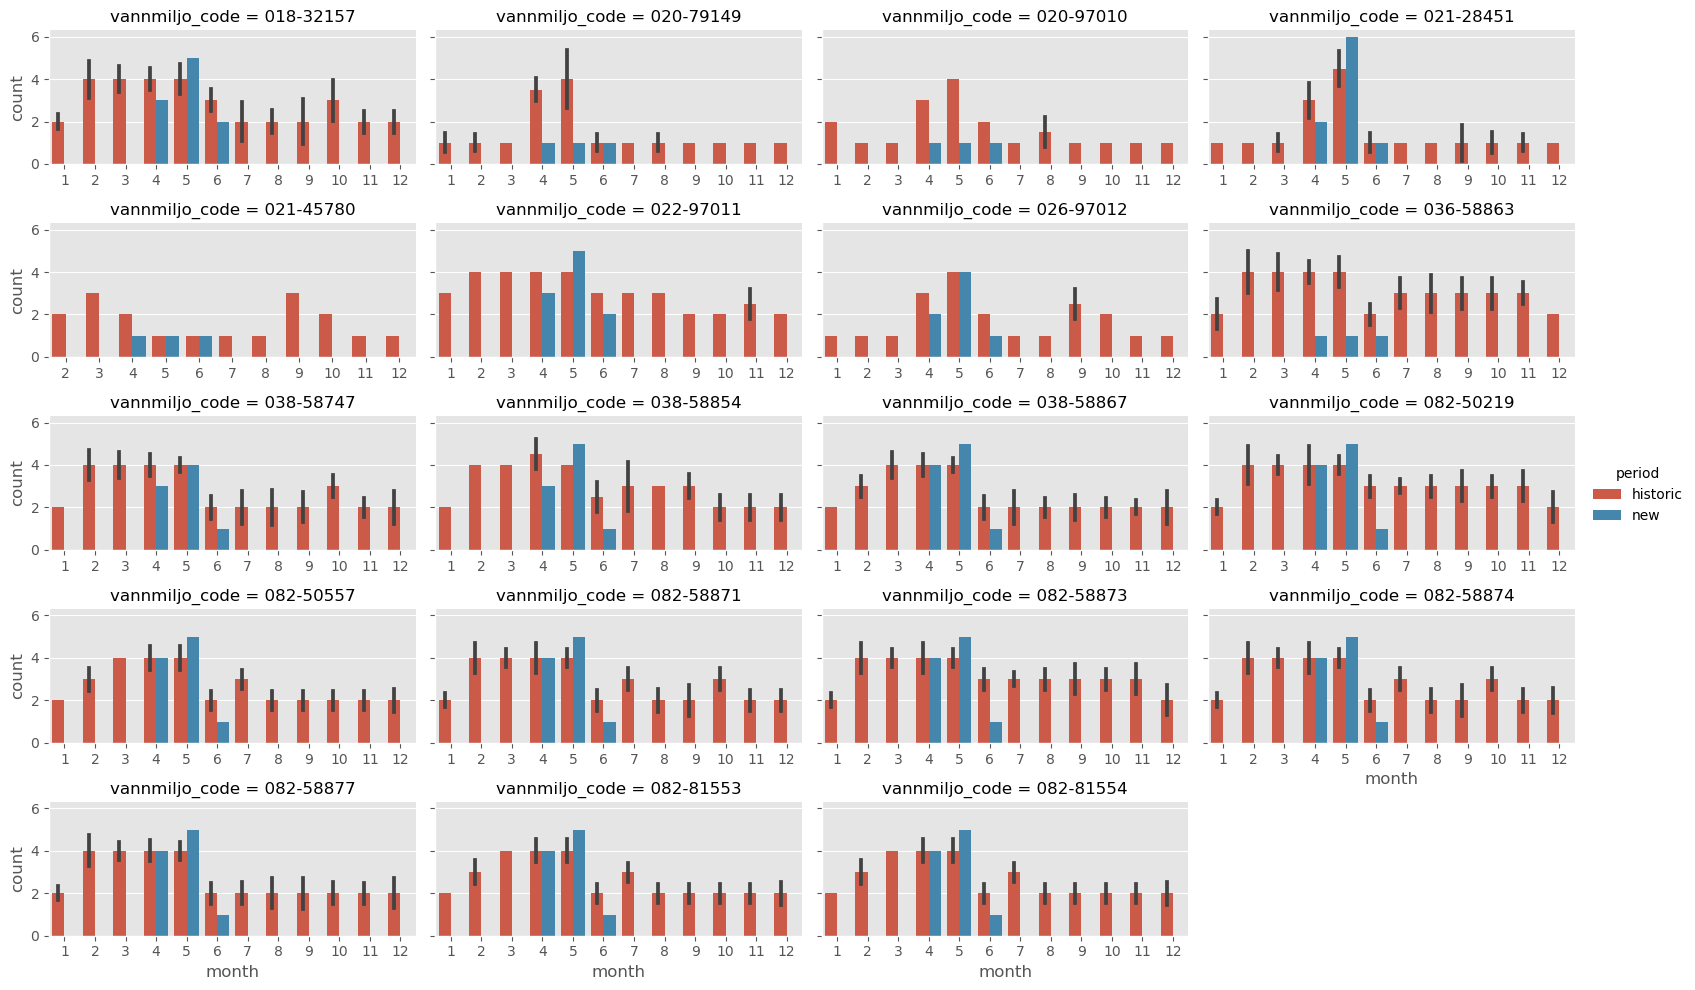

In [6]:
# Bar plots of monthly historic and new sampling frequencies for just these stations
df2 = df.query("vannmiljo_code in @below_min_stns").copy()
df2 = (
    df2.groupby(["vannmiljo_code", "period", "year", "month"])
    .count()["count"]
    .reset_index()
)

sn.catplot(
    data=df2,
    x="month",
    y="count",
    kind="bar",
    hue="period",
    hue_order=["historic", "new"],
    col="vannmiljo_code",
    col_wrap=4,
    estimator=np.median,
    ci="sd",
    height=2,
    aspect=2,
    sharex=False,
)
png_path = os.path.join(fold_path, "samp_freq_below_historic_min_plot.png")
plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 2. Outliers per site

The code below checks for outliers in individual data series (where a "data series" is defined as a unique combination of station code, parameter and depth information). The interquartile range (IQR) for the historic data is first calculated, then outliers in the "new" data are identified if values are either: 

 * More than **`iqr_fac` * IQR above the upper quartile**, or
 * Less than **`iqr_fac` * IQR below the lower quartile**
 
The usual choice for `iqr_fac` is 1.5. This is commonly used in e.g. boxplots to define the boundary between the "whiskers" and the "outliers". However, using `iqr_fac = 1.5` here identifies a large number of potential outliers, so to keep data volumes more manageable I have chosen the much more extreme value of 3 for now. This can be relaxed later if necessary.

Note that plots are only shown for data series with **at least 50 measurements** in the historic period, to ensure the historic IQR can be estimated robustly.

In [7]:
# Read from SQLite
stn_df, df = utils.read_data_from_sqlite(lab, year, qtr, version)

# # Subset data to just the quarter of interest
# months_dict = {
#     "q1": [1, 2, 3],
#     "q2": [4, 5, 6],
#     "q3": [7, 8, 9],
#     "q4": [10, 11, 12],
# }
# months = months_dict[qtr]
# df = df[df["sample_date"].dt.month.isin(months)]

df = df.melt(
    id_vars=["vannmiljo_code", "sample_date", "lab", "period", "depth1", "depth2"],
    var_name="par",
)
df.dropna(subset=["value"], inplace=True)
df.head()

,vannmiljo_code,sample_date,lab,period,depth1,depth2,par,value
3,002-105961,2023-05-01,Eurofins,new,0.0,0.0,ALK_mmol/l,0.030
8,002-105961,2023-06-05,Eurofins,new,0.0,0.0,ALK_mmol/l,0.030
95,002-58798,2014-09-01,NIVA (historic),historic,0.0,0.0,ALK_mmol/l,0.055
98,002-58798,2014-10-06,NIVA (historic),historic,0.0,0.0,ALK_mmol/l,0.060
100,002-58798,2014-11-03,NIVA (historic),historic,0.0,0.0,ALK_mmol/l,0.020


In [8]:
df_list = []
grps = df.groupby(["vannmiljo_code", "par", "depth1", "depth2"])
for idx, grp_df in grps:
    grp_df.set_index("sample_date", inplace=True)
    grp_df.sort_index(inplace=True)
    his_df = grp_df.query("period == 'historic'").copy()
    new_df = grp_df.query("period == 'new'").copy()

    if (len(his_df) > 50) and (len(new_df) > 0):
        new_df["outlier"] = 0
        uq = his_df["value"].quantile(0.75)
        lq = his_df["value"].quantile(0.25)
        iqr = uq - lq
        new_df.loc[new_df["value"] > uq + iqr_fac * iqr, "outlier"] = 1
        new_df.loc[new_df["value"] < lq - iqr_fac * iqr, "outlier"] = 1

        df_list.append(new_df.query("outlier != 0"))

out_df = pd.concat(df_list)
n_stns = len(out_df["vannmiljo_code"].unique())
print(
    f"There are {len(out_df)} records from {n_stns} stations with new data values that are more than {iqr_fac}*IQR above or below the historic IQR.\n"
)
csv_path = os.path.join(fold_path, "timerseries_outliers.csv")
out_df2 = out_df.reset_index()
out_df2.to_csv(csv_path, index=False)
out_df.head()

There are 43 records from 19 stations with new data values that are more than 4*IQR above or below the historic IQR.



,vannmiljo_code,lab,period,depth1,depth2,par,value,outlier
sample_date,,,,,,,,
2023-06-04,020-58795,Eurofins,new,0.0,0.0,KOND_mS/m,5.02,1
2023-06-04,020-58795,Eurofins,new,0.0,0.0,PH_<ubenevnt>,4.10,1
2023-05-26,021-28450,Eurofins,new,0.0,0.0,CA_mg/l,6.90,1
2023-05-29,021-28450,Eurofins,new,0.0,0.0,CA_mg/l,8.60,1
2023-06-05,021-28450,Eurofins,new,0.0,0.0,CA_mg/l,11.00,1


### 2.1. Annotate outliers in Excel

**Added 09.08.2022**

During a meeting on 08.06.2022, it was agreed that the workflow should be modified such that the outliers identified above are automatically annotated in a copy of the original Excel file from Eurofins (as well as being displayed online in interactive plots as previously - see below). See the e-mail from Kjetil received 09.06.2022 at 18:25 for more information.

The main idea is to add a Boolean column named e.g. `timeseries_outlier` to the end of the Excel file. This can be used to identify any water sample containing one of more outliers flagged using the method above. The outlying values themselves (i.e. specific parameter values, rather than the whole water sample) can then be identified by e.g. yellow highlighting. 

**Note:** This modification will *only* incorporate results from the time series analysis (e.g. files named `timeseries_outliers.csv`). It does not include information from the other statistical assessments, such as the distribution plots and isolation forest. Results from these analyses will be made available on the website, as before, but they still require manual review.

**Note 2:** Duplicated records (i.e. same station_code-date-depth-parameter, but different value) are ignored in the assessment of time series outliers, because we assume only one value per time point per series. Duplicates will have been highlighted previously by the app, but if they are still present in the dataset (e.g. because they are genuine flomprøver), they will nevertheless be ignored here.

In [9]:
# Copy data template
raw_xl_path = f"../../data/{lab.lower()}_data_{year}_q{qtr}_v{version}.xlsx"
out_xl_path = f"../../output/{lab.lower()}_{year}_q{qtr}_v{version}/{lab.lower()}_data_{year}_q{qtr}_v{version}_outliers.xlsx"
shutil.copyfile(raw_xl_path, out_xl_path)

# Set colours for cell highlighting
outlier_colour = PatternFill(
    start_color="00FFFF00", end_color="00FFFF00", fill_type="solid"
)
header_colour = PatternFill(
    start_color="FF00B0F0", end_color="FF00B0F0", fill_type="solid"
)

# Open worksheet
wb = load_workbook(out_xl_path)
ws = wb["results"]

# Add new header column
ws.column_dimensions["AE"].width = 25
ws["AE3"].value = "TimeSeriesOutlier"
ws["AE3"].font = Font(bold=True)
ws["AE3"].alignment = Alignment(horizontal="center")
for row in ws["AE1:AE3"]:
    for cell in row:
        cell.fill = header_colour

# Build mapping for (stn_id, date) => row_idx
stn_ids = [cell.value for cell in ws["C"]][3:]
dates = [cell.value for cell in ws["G"]][3:]
row_nums = list(range(4, len(stn_ids) + 4))
row_idx_df = pd.DataFrame({"stn_id": stn_ids, "date": dates, "row_num": row_nums})

# Mapping for Vannmiljø par names => col_idx
col_idx_dict = {
    "TEMP": 9,
    "PH": 10,
    "KOND": 11,
    "ALK": 12,
    "P-TOT": 14,
    "N-TOT": 15,
    "N-NO3": 16,
    "TOC": 17,
    "RAL": 18,
    "ILAL": 19,
    "LAL": 20,
    "CL": 21,
    "SO4": 22,
    "CA": 23,
    "K": 24,
    "MG": 25,
    "NA": 26,
    "SIO2": 27,
    "ANC": 28,
}

# Loop over outliers
for idx, row in out_df.iterrows():
    stn_id = row["vannmiljo_code"]
    date = idx
    par = row["par"].split("_")[0]

    # Determine row
    out_row_idx_df = row_idx_df.query("(stn_id == @stn_id) and (date == @date)")
    assert (
        len(out_row_idx_df) == 1
    ), f"Multiple rows found in spreadsheet for {stn_id} on {date}."
    row_idx = out_row_idx_df["row_num"].iloc[0]

    # Determine column
    col_idx = col_idx_dict[par]

    # Highlight outlier value and set 'TimeSeriesOutlier' column to 1
    ws.cell(row=row_idx, column=col_idx).fill = outlier_colour
    ws.cell(row=row_idx, column=31).value = 1

# Fill gaps in 'TimeSeriesOutlier' column with zeros
for cell in ws["AE"]:
    if (cell.row > 3) and (cell.value != 1):
        cell.value = 0

# Apply filter to all cols and save
ws.auto_filter.ref = ws.dimensions
wb.save(out_xl_path)

### 2.2. Interactive time series plots

In [10]:
out_df.reset_index(inplace=True)
out_df["temp"] = out_df["vannmiljo_code"] + "_" + out_df["par"]
df["temp"] = df["vannmiljo_code"] + "_" + df["par"]
filt = list(out_df["temp"].unique())
df = df.query("temp in @filt")
del df["temp"], out_df["temp"]
out_df = out_df[["vannmiljo_code", "sample_date", "depth1", "depth2", "par", "outlier"]]
df = pd.merge(
    df,
    out_df,
    on=["vannmiljo_code", "sample_date", "depth1", "depth2", "par"],
    how="left",
)
df["outlier"].fillna(0, inplace=True)
df["series"] = (
    df["vannmiljo_code"]
    + " "
    + df["par"]
    + " ("
    + df["depth1"].astype(int).astype(str)
    + " m, "
    + df["depth2"].astype(int).astype(str)
    + " m)"
)

df["vline"] = dt.datetime(2021, 1, 1)

df.head()

,vannmiljo_code,sample_date,lab,period,depth1,depth2,par,value,outlier,series,vline
0,023-58887,2012-08-06,NIVA (historic),historic,0.0,0.0,ANC_µekv/l,57.869,0.0,"023-58887 ANC_µekv/l (0 m, 0 m)",2021-01-01
1,023-58887,2012-09-03,NIVA (historic),historic,0.0,0.0,ANC_µekv/l,69.162,0.0,"023-58887 ANC_µekv/l (0 m, 0 m)",2021-01-01
2,023-58887,2012-10-01,NIVA (historic),historic,0.0,0.0,ANC_µekv/l,60.767,0.0,"023-58887 ANC_µekv/l (0 m, 0 m)",2021-01-01
3,023-58887,2012-10-17,NIVA (historic),historic,0.0,0.0,ANC_µekv/l,50.803,0.0,"023-58887 ANC_µekv/l (0 m, 0 m)",2021-01-01
4,023-58887,2012-10-29,NIVA (historic),historic,0.0,0.0,ANC_µekv/l,57.446,0.0,"023-58887 ANC_µekv/l (0 m, 0 m)",2021-01-01


In [11]:
# Build drop-down list
series_list = ["None"] + sorted(df["series"].unique())
input_dropdown = alt.binding_select(options=series_list)
selection = alt.selection_single(fields=["series"], bind=input_dropdown, name="Select")

/opt/conda/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_single' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [12]:
base = alt.Chart(df, height=400, width=800, title="Time series plots")

# Set max on x-axis to 1 month after last day in qtr
if qtr == 1:
    end_date = f"{year}-04-30"
elif qtr == 2:
    end_date = f"{year}-07-31"
elif qtr == 3:
    end_date = f"{year}-10-31"
else:
    end_date = f"{year+1}-01-31"
time_domain = pd.to_datetime(["2011-01-01", end_date]).astype(int) / 10**6

series = (
    base.add_selection(selection)
    .transform_filter(selection)
    .mark_line(point=True)
    .encode(
        #  x="sample_date:T",
        x=alt.X(
            "sample_date:T", title="Value", scale=alt.Scale(domain=list(time_domain))
        ),
        y="value:Q",
        tooltip=[
            "vannmiljo_code",
            "sample_date",
            "lab",
            "period",
            "depth1",
            "depth2",
            "par",
            "value",
            "outlier",
        ],
    )
    .interactive()
)

points = (
    base.transform_filter(selection)
    .mark_circle()
    .encode(
        x=alt.X("sample_date:T", title="Value"),
        y="value:Q",
        color=alt.Color(
            "outlier:N", scale=alt.Scale(domain=[0, 1], range=["black", "red"])
        ),
    )
)

vline = base.mark_rule(color="red").encode(
    x=alt.X("vline:T", title="Value"),
)

chart = series + points + vline
chart.save("timeseries_plots.json")

/opt/conda/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


In [13]:
# Move json files to 'output' folder
flist = glob.glob("*.json")
for fpath in flist:
    shutil.copy(fpath, fold_path)
    os.remove(fpath)

# Copy HTML page too
shutil.copy(r"../../pages/timeseries_plots.html", fold_path)

'../../output/eurofins_2023_q2_v1/timeseries_plots.html'